# Решение тестового задания Стажировки в ВК

### Импорт библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_117747/3698959207.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Загрузка данных

In [2]:
train_data = pd.read_csv("data/trainee_train.csv")

In [3]:
train_data

,Unnamed: 0,im,v1,v2,v3,v4,v5,v6,v7,v8,...,v437,v438,v439,v440,v441,v442,v443,v444,v445,v446
0,0,0.0,128.100243,128.157072,129.255102,128.273006,126.532819,129.023232,129.854839,129.828431,...,128.800985,128.232694,128.211893,130.512476,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
1,1,1.0,128.100243,128.157072,126.636364,128.273006,130.810403,129.023232,128.633333,128.994152,...,128.914365,128.232694,128.211893,128.167519,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
2,2,1.0,128.100243,128.157072,129.255102,128.273006,130.810403,129.023232,126.769231,126.926295,...,128.800985,128.232694,128.211893,128.167519,128.051724,127.709786,127.349282,127.063052,125.169118,125.274194
3,3,1.0,128.100243,128.157072,127.630027,128.273006,126.532819,129.023232,126.769231,126.926295,...,128.800985,130.794007,131.026119,130.512476,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
4,4,1.0,128.100243,128.336364,129.255102,128.273006,130.810403,126.042980,129.854839,126.926295,...,128.800985,130.794007,131.026119,130.512476,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,611,0.0,128.100243,128.157072,129.255102,128.273006,130.810403,129.023232,129.854839,129.828431,...,128.800985,128.232694,128.211893,126.744108,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
612,612,1.0,128.100243,128.157072,129.255102,128.273006,126.532819,129.023232,126.769231,126.926295,...,128.800985,128.232694,128.211893,126.744108,130.411160,130.650165,130.904685,131.017268,130.477398,130.496150
613,613,1.0,130.798507,131.174905,129.255102,117.900000,132.860465,130.381148,129.854839,129.828431,...,128.914365,128.232694,128.211893,128.167519,128.051724,127.709786,127.349282,127.063052,125.169118,126.611554
614,614,1.0,128.100243,128.157072,129.255102,128.273006,126.532819,129.023232,129.854839,126.926295,...,128.800985,128.232694,128.211893,128.167519,128.051724,127.709786,127.349282,127.063052,130.477398,130.496150


<BarContainer object of 2 artists>

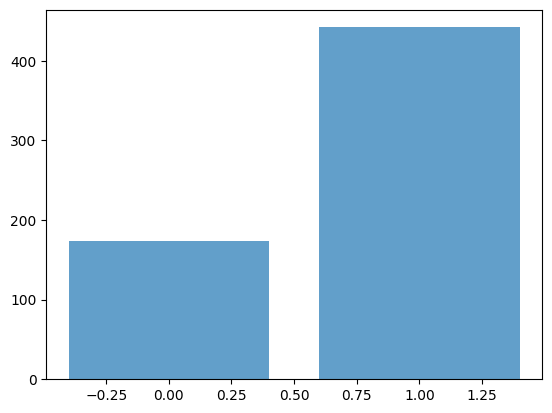

In [4]:
unique_classes, class_counts = np.unique(train_data['im'], return_counts=True)
plt.bar(unique_classes, class_counts, align='center', alpha=0.7)

In [5]:
X = train_data.drop('im', axis=1)
y = train_data['im']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Логистическая регрессия

In [8]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), #normalize data
    ('model', LogisticRegression(penalty="l2")) #classifier
])

p = {
    "model__C": [0.0464] #np.logspace(-4,4,10)
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=p,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10,
)
logreg = grid_search.fit(X, y)

In [9]:
print(f"best score: {logreg.best_score_}")
print(f"best params: {logreg.best_params_}")

best score: 0.9272162804515747
best params: {'model__C': 0.0464}


### Cлучайный лес

In [10]:
classifier = RandomForestClassifier(n_estimators=200, random_state=42)


PARAMS = {
    "min_samples_split": [5], #range(5, 200, 10),
    "min_samples_leaf": [1] #range(1, 100, 10),
}


grid_search = GridSearchCV(classifier, PARAMS, scoring="roc_auc", cv=5)
rf = grid_search.fit(X, y);

In [11]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

Best score: 0.9243824516527755
Best params: {'min_samples_leaf': 1, 'min_samples_split': 5}


### Метод ближайших соседей

In [12]:
PARAMS = {
    "model__n_neighbors": [11] # range(1, 100, 5),
}

clf = Pipeline(steps=[
    ('scaler', StandardScaler()), #normalize data
    ('model', KNeighborsClassifier()) #classifier
])
    
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10
)
knn = grid_search.fit(X, y)

In [13]:
print(f"Best score: {knn.best_score_}")
print(f"Best params: {knn.best_params_}")

Best score: 0.9154062685680333
Best params: {'model__n_neighbors': 11}


### CatBoost

In [14]:
param_grid = {
    'l2_leaf_reg': [3], # [3, 5, 7, 10],
    'depth': [6], #[4, 6, 8],
    'learning_rate': [0.05], #[0.01, 0.05, 0.1],
    'iterations': [500] #[100, 200, 300, 500]
}


# Создание модели CatBoost
base_model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_seed=42)

# Использование GridSearchCV для поиска по сетке
catboost = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='roc_auc', cv=3)


In [15]:
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50)

0:	test: 0.8138763	best: 0.8138763 (0)	total: 56.3ms	remaining: 28.1s
50:	test: 0.9101056	best: 0.9128205 (49)	total: 164ms	remaining: 1.44s
100:	test: 0.9212670	best: 0.9212670 (100)	total: 262ms	remaining: 1.04s
150:	test: 0.9279035	best: 0.9279035 (150)	total: 362ms	remaining: 837ms
200:	test: 0.9312217	best: 0.9324284 (171)	total: 457ms	remaining: 680ms
250:	test: 0.9333333	best: 0.9336350 (248)	total: 556ms	remaining: 552ms
300:	test: 0.9324284	best: 0.9345400 (274)	total: 654ms	remaining: 432ms
350:	test: 0.9330317	best: 0.9345400 (274)	total: 750ms	remaining: 318ms
400:	test: 0.9336350	best: 0.9345400 (274)	total: 849ms	remaining: 210ms
450:	test: 0.9327300	best: 0.9345400 (274)	total: 946ms	remaining: 103ms
499:	test: 0.9330317	best: 0.9345400 (274)	total: 1.04s	remaining: 0us

bestTest = 0.9345399698
bestIteration = 274

Shrink model to first 275 iterations.
0:	test: 0.7473605	best: 0.7473605 (0)	total: 2.98ms	remaining: 1.49s
50:	test: 0.9064857	best: 0.9092006 (46)	total: 10

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd9fae9f310>,
             param_grid={'depth': [6], 'iterations': [500], 'l2_leaf_reg': [3],
                         'learning_rate': [0.05]},
             scoring='roc_auc')

In [16]:
best_params = catboost.best_params_
print(f"Best score: {catboost.best_score_}")
print(f'Best Parameters: {best_params}')

Best score: 0.925739184562714
Best Parameters: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05}


In [21]:
y_pred = catboost.predict_proba(X_test)[:, 1]

# Вычисление ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc}')

ROC-AUC: 0.9405731523378582


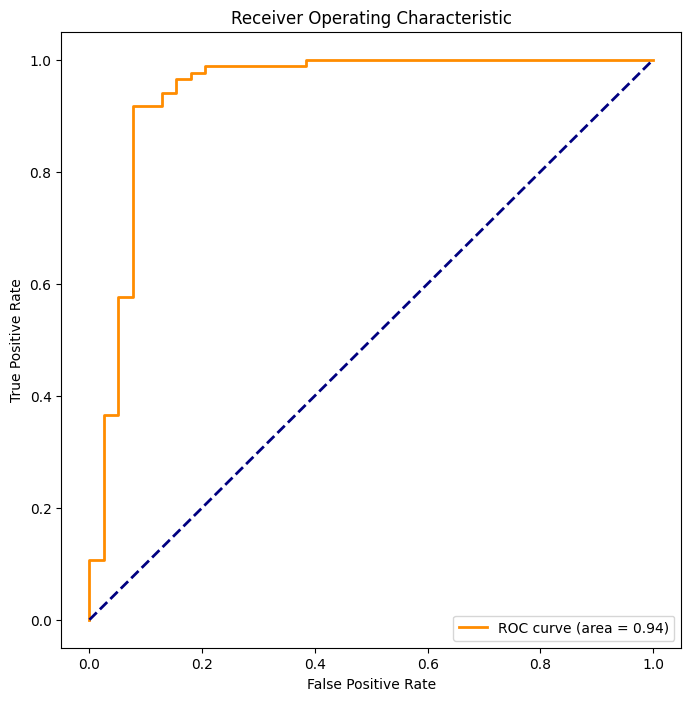

In [22]:
# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Stacking

In [18]:
final = CatBoostClassifier(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.05,
    max_depth=15,
    min_data_in_leaf=10,
    n_estimators=20,
    random_strength=11,
    subsample=0.1,
)

stacking = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("rf", rf),
        # ("catboost", catboost),
        ("knn", knn)
    ],
    final_estimator=final,
    n_jobs=-1,
)

stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('logreg',
                                GridSearchCV(cv=10,
                                             estimator=Pipeline(steps=[('scaler',
                                                                        StandardScaler()),
                                                                       ('model',
                                                                        LogisticRegression())]),
                                             n_jobs=-1,
                                             param_grid={'model__C': [0.0464]},
                                             scoring='roc_auc')),
                               ('rf',
                                GridSearchCV(cv=5,
                                             estimator=RandomForestClassifier(n_estimators=200,
                                                                              random_state=42),
                                             param_grid={'min_samples_leaf': [1],
                                                         'min_samples_split': [5]},
                                             scoring='roc_auc')),
                               ('knn',
                                GridSearchCV(cv=10,
                                             estimator=Pipeline(steps=[('scaler',
                                                                        StandardScaler()),
                                                                       ('model',
                                                                        KNeighborsClassifier())]),
                                             n_jobs=-1,
                                             param_grid={'model__n_neighbors': [11]},
                                             scoring='roc_auc'))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x7fda20577010>,
                   n_jobs=-1)

In [19]:
y_pred = stacking.predict_proba(X_test)[:, 1]

# Вычисление ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc}')

ROC-AUC: 0.9159879336349924


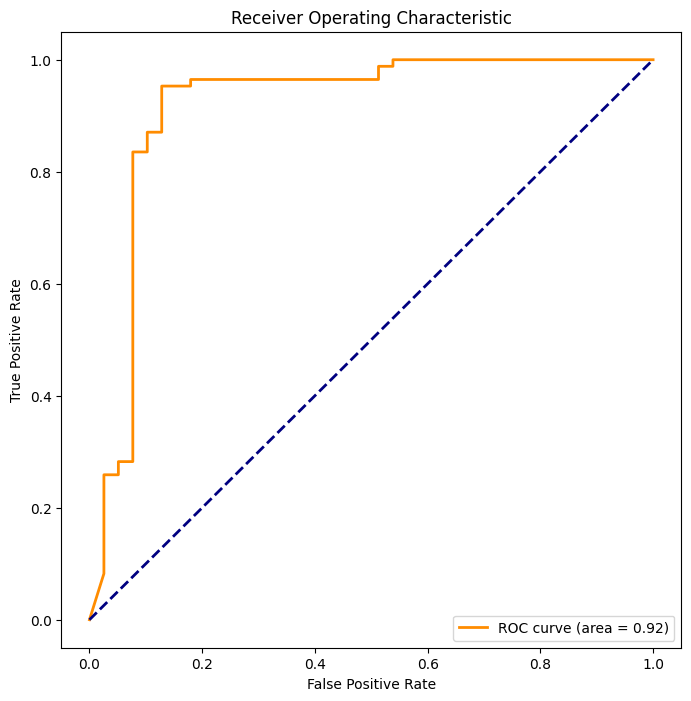

In [20]:
# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_data = pd.read_csv("data/trainee_test_fish.csv")

In [ ]:
submission = pd.DataFrame()
submission["im"] = stacking.predict_proba(test_data)[:, 1]
submission.to_csv("Submission/stacking.csv", index=True)

In [ ]:
submission = pd.DataFrame()
submission["im"] = catboost.predict_proba(test_data)[:, 1]
submission.to_csv("Submission/catboost.csv", index=True)